<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/1_Euler_beam_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem setup
We will solve an ODE:
$$\frac{\partial^{4} u}{\partial x^4} + 1 = 0, \qquad x \in [0, 1],$$
with two boundary conditions on the right boundary,
$$u''(1)=0,   u'''(1)=0$$
and one Dirichlet boundary condition on the left boundary,
$$u(0)=0$$
along with one Neumann boundary condition on the left boundary,
$$u'(0)=0$$
The exact solution is
$$u(x) = -\frac{1}{24}x^4+\frac{1}{6}x^3-\frac{1}{4}x^2$$

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Linear(1, 50),
      nn.Tanh(),
      nn.Linear(50, 50),
      nn.Tanh(),
      nn.Linear(50, 50),
      nn.Tanh(),
      nn.Linear(50, 1)
    )

  def forward(self, x):
    x = self.layer1(x)
    return x

In [8]:
def pde_loss(model, x):
  y_pred = model(x)
  y_t = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x, create_graph=True)[0]
  y_tttt = torch.autograd.grad(y_ttt.sum(), x, create_graph=True)[0]
  loss = (y_tttt + 1).pow(2).mean()
  return loss

def bc_loss1(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  loss = y_pred.pow(2) + y_t.pow(2)
  return loss

def bc_loss2(model, x_bc):
  y_pred = model(x_bc)
  y_t = torch.autograd.grad(y_pred.sum(), x_bc, create_graph=True)[0]
  y_tt = torch.autograd.grad(y_t.sum(), x_bc, create_graph=True)[0]
  y_ttt = torch.autograd.grad(y_tt.sum(), x_bc, create_graph=True)[0]
  loss = y_tt.pow(2) + y_ttt.pow(2)
  return loss

def y_exact(x):
  return -1/24*x**4 + 1/6*x**3 - 1/4*x**2

In [9]:
# Collocation & Boundary Points
x_domain = [0., 1.]
x = torch.rand((100,1))*x_domain[1]
x.requires_grad_()
x_bc1 = torch.tensor([0.]).requires_grad_()
x_bc2 = torch.tensor([1.]).requires_grad_()
# y_bc1 = torch.tensor([0.])
# y_bc2 = torch.tensor([1.])

In [10]:
model = Network()
# torch.optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20000
for epoch in range(n_epochs):
  pde_res = pde_loss(model, x)
  bound_loss1 = bc_loss1(model, x_bc1)
  bound_loss2 = bc_loss2(model, x_bc2)
  loss = pde_res + bound_loss1 + bound_loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}')

Epoch: 0, Loss: 1.5
Epoch: 1000, Loss: 9e-06
Epoch: 2000, Loss: 3.7e-06
Epoch: 3000, Loss: 1.1e-05
Epoch: 4000, Loss: 1.5e-06
Epoch: 5000, Loss: 1.1e-06
Epoch: 6000, Loss: 7.3e-07
Epoch: 7000, Loss: 3.4e-06
Epoch: 8000, Loss: 5.7e-07
Epoch: 9000, Loss: 3.7e-06
Epoch: 10000, Loss: 1.6e-05
Epoch: 11000, Loss: 3.7e-06
Epoch: 12000, Loss: 4.6e-07
Epoch: 13000, Loss: 4.7e-07
Epoch: 14000, Loss: 1e-06
Epoch: 15000, Loss: 5.8e-06
Epoch: 16000, Loss: 2.8e-06
Epoch: 17000, Loss: 1.1e-05
Epoch: 18000, Loss: 2.4e-05
Epoch: 19000, Loss: 2.8e-07


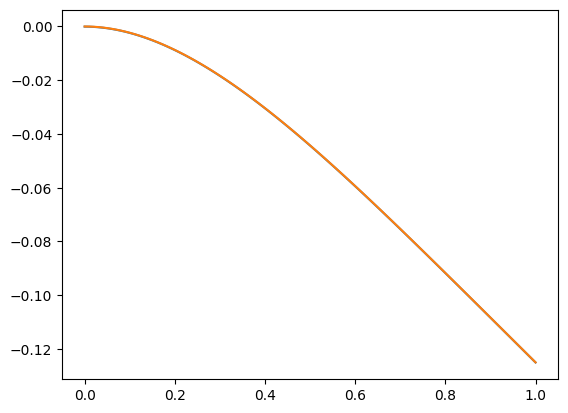

In [11]:
# Validation
x_test = torch.from_numpy(np.linspace(0,1,100)).type(torch.float32)[:,None]
y_test = model(x_test)

x_true = np.linspace(0, 1, 100)
y_true = y_exact(x_true)

plt.figure()
plt.plot(x_test.detach().numpy(), y_test.detach().numpy())
plt.plot(x_true, y_true)
plt.show()

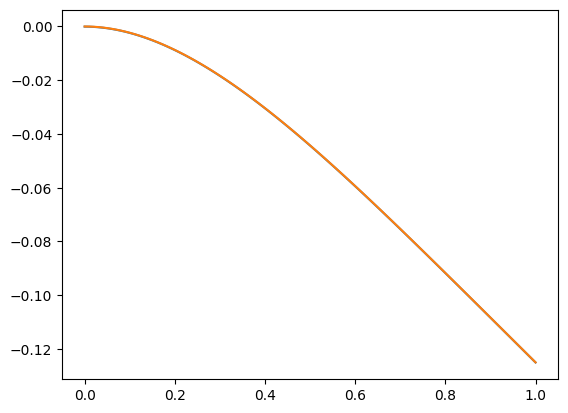

In [ ]:
# Validation
x_test = torch.from_numpy(np.linspace(0,1,100)).type(torch.float32)[:,None]
y_test = model(x_test)

x_true = np.linspace(0, 1, 100)
y_true = y_exact(x_true)

plt.figure()
plt.plot(x_test.detach().numpy(), y_test.detach().numpy())
plt.plot(x_true, y_true)
plt.show()